# 导入基本库
SimpleITK==2.3.0

numpy==1.23.5

lungmask==0.2.20

torch==1.11.0+cu113

transformers==4.46.3

pkuseg==0.0.25

In [1]:
import os
import SimpleITK as sitk
import numpy as np
from lungmask import LMInferer
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import math
import cv2
import torch

import re

import pandas as pd
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import pkuseg
import json

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CT影像预处理函数

In [2]:
# CT影像读取及肺部掩膜提取函数
def lung_mask_extract(image_files_path, image_format='DICOM'):
    '''
    Input:
        image_files_path: CT图像保存地址
        image_format：CT图像格式，支持NII和DICOM
    Output:
        image_npy: np.array格式肺部掩膜图像
    '''
    if image_format == "DICOM":
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(image_files_path)
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
    elif image_format == "NII":
        image = sitk.ReadImage(image_files_path)
    else:
        raise ValueError(f"Unsupported image format, please input images in format of NII or DICOM.")
    image_npy = sitk.GetArrayFromImage(image)

    spacing_npy = np.array(list(reversed(image.GetSpacing())))
    direction = image.GetDirection()

    # Check if a flip is needed based on the direction cosines
    transformM = np.array(direction).reshape(3, 3)
    transformM = np.round(transformM)
    isflip = np.any(transformM != np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('device: ', device)
    inferer = LMInferer()
    inferer.device = device
    inferer.model.to(device)
    lung_mask = inferer.apply(image)

    binary_mask = (lung_mask == 1) | (lung_mask == 2)
    image_npy[~binary_mask] = 0

    if isflip:
        image_npy = image_npy[:, ::-1, ::-1]
    return image_npy

# CT影像中心区域截取
def center_crop(image, crop_size=(384, 384)):
    '''
    Input:
        image: np.array格式肺部掩膜图像
    Output:
        cropped_image: 中心区域截取后图像
    '''
    n, h, w = image.shape
    new_h, new_w = crop_size

    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2

    cropped_image = image[:, start_h:start_h + new_h, start_w:start_w + new_w]
    return cropped_image

# 像素标准化函数
def normalize_slices_ignore_zeros(slices, means, stds):
    '''
    Input:
        slices: np.array格式肺部掩膜图像（冠状面）
        means: np.array格式每张slice的非0像素均值
        stds: np.array格式每张slice的非0像素标准差
    Output:
        slices: 标准化后np.array格式肺部掩膜图像（冠状面）
    '''
    slices = slices.astype(np.float32, copy=False)
    for i in range(slices.shape[0]):
        mask = slices[i, :, :] != 0
        slices[i, :, :][mask] = (slices[i, :, :][mask] - means[i]) / stds[i]
    return slices

# 轴状面视角转换为冠状面视角，并保留10张slice
def CT_lung_mask_2_X_ray_10(lung_mask, pixel_means, pixel_stds, crop_size=(384, 384), target_shape=(256,256), show_img=False, device='cpu'):
    S=20
    CT_lung_mask_image_npy = lung_mask
    slice_num = CT_lung_mask_image_npy.shape[1]
    if slice_num > 50:
        cut_image = CT_lung_mask_image_npy[:, 30:-20, :]
    else:
        raise ValueError("The slice number of CT is too small!")
    slice_num = cut_image.shape[1]
    sub_slice_num = slice_num // S
    indices = [sub_slice_num * i + sub_slice_num // 2 for i in range(S)]
    Xray_lung_mask_image_npy = cut_image[:, indices, :]
    Xray_lung_mask_image_npy = Xray_lung_mask_image_npy.transpose(1, 0, 2)
    Xray_lung_mask_image_npy = Xray_lung_mask_image_npy[:, ::-1, :]

    H = Xray_lung_mask_image_npy.shape[1]
    W = Xray_lung_mask_image_npy.shape[2]
    if H > crop_size[0] and W > crop_size[1]:
        cropped_image = center_crop(Xray_lung_mask_image_npy, crop_size=crop_size)
    else:
        cropped_image = Xray_lung_mask_image_npy
    cropped_image = cropped_image.astype(np.float32)
    resized_image = np.zeros((S, target_shape[0], target_shape[1]), dtype=np.float32)
    for i in range(cropped_image.shape[0]):
        resized_image[i] = cv2.resize(cropped_image[i], target_shape)
    resized_image = resized_image[5:15]
    resized_image = np.clip(resized_image, -3000, 3000)
    # resized_image = normalize_slices_ignore_zeros(resized_image, pixel_means, pixel_stds)
    if show_img:
        fig_num = 10
        fig, ax = plt.subplots(2, 5, figsize=(50, 20))
        ax = ax.flatten()
        for j in range(fig_num):
            ax[j].imshow(resized_image[j], cmap='gray', vmin=-1200, vmax=600)
        plt.show()
    resized_image = normalize_slices_ignore_zeros(resized_image, pixel_means, pixel_stds)
    return torch.tensor(resized_image, dtype=torch.float32).unsqueeze(0).to(device)

# 文本处理、嵌入函数

In [3]:
def ct_report_embedding(ct_report, model, tokenizer, seg, all_auc_dicts, device='cpu'):
    ct_report = re.sub(r'[A-Za-z0-9]', '', ct_report)
    sentences = re.split(r'[。，；、;,:\??]', ct_report)
    sentences = [re.sub(r'[- ×＝*\.≈/㎝\\]', '', s) for s in sentences if s.strip()]
    tokens = []
    for s in sentences:
        tokens += seg.cut(s)
    filtered_tokens = []
    for token in tokens:
        if token in all_auc_dicts["fev1_auc_sorted_dict"] and all_auc_dicts["fev1_auc_sorted_dict"][token] > 0:
            filtered_tokens.append(token)
            continue
        if token in all_auc_dicts["fvc_auc_sorted_dict"] and all_auc_dicts["fvc_auc_sorted_dict"][token] > 0:
            filtered_tokens.append(token)
            continue
        if token in all_auc_dicts["tlc_auc_sorted_dict"] and all_auc_dicts["tlc_auc_sorted_dict"][token] > 0:
            filtered_tokens.append(token)
            continue
    if len(filtered_tokens) >= 1:
        if len(filtered_tokens) == 1:
            filtered_ct_report = filtered_tokens[0]
        else:
            filtered_ct_report = ' '.join(list(set(filtered_tokens)))
        inputs = tokenizer(filtered_ct_report, return_tensors='pt', padding=True, truncation=True,
                           max_length=48).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        ct_report_embedding = outputs.last_hidden_state[:, 0, :].to(device)
        prefix = torch.tensor([[1.0]], dtype=torch.float32).to(device)
        ct_report_embedding_tensor = torch.cat([prefix, ct_report_embedding], dim=1).to(torch.float32).to(device)
    else:
        ct_report_embedding_tensor = torch.zeros((1, 769), dtype=torch.float32).to(device)
    
    return ct_report_embedding_tensor

def llm_reasonings_embedding(reasonings, model, tokenizer, device='cpu'):
    inputs = tokenizer(reasonings, return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    llm_reasonings_embedding_tensor = outputs.last_hidden_state
    return llm_reasonings_embedding_tensor.to(torch.float32).unsqueeze(0).to(device)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');

# 输入1（必须）：CT图像输入，支持NII和DICOM版本CT影像

device:  cuda


20it [00:02,  8.95it/s]                          

lungmask 2025-08-11 05:41:16 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 113.98it/s]


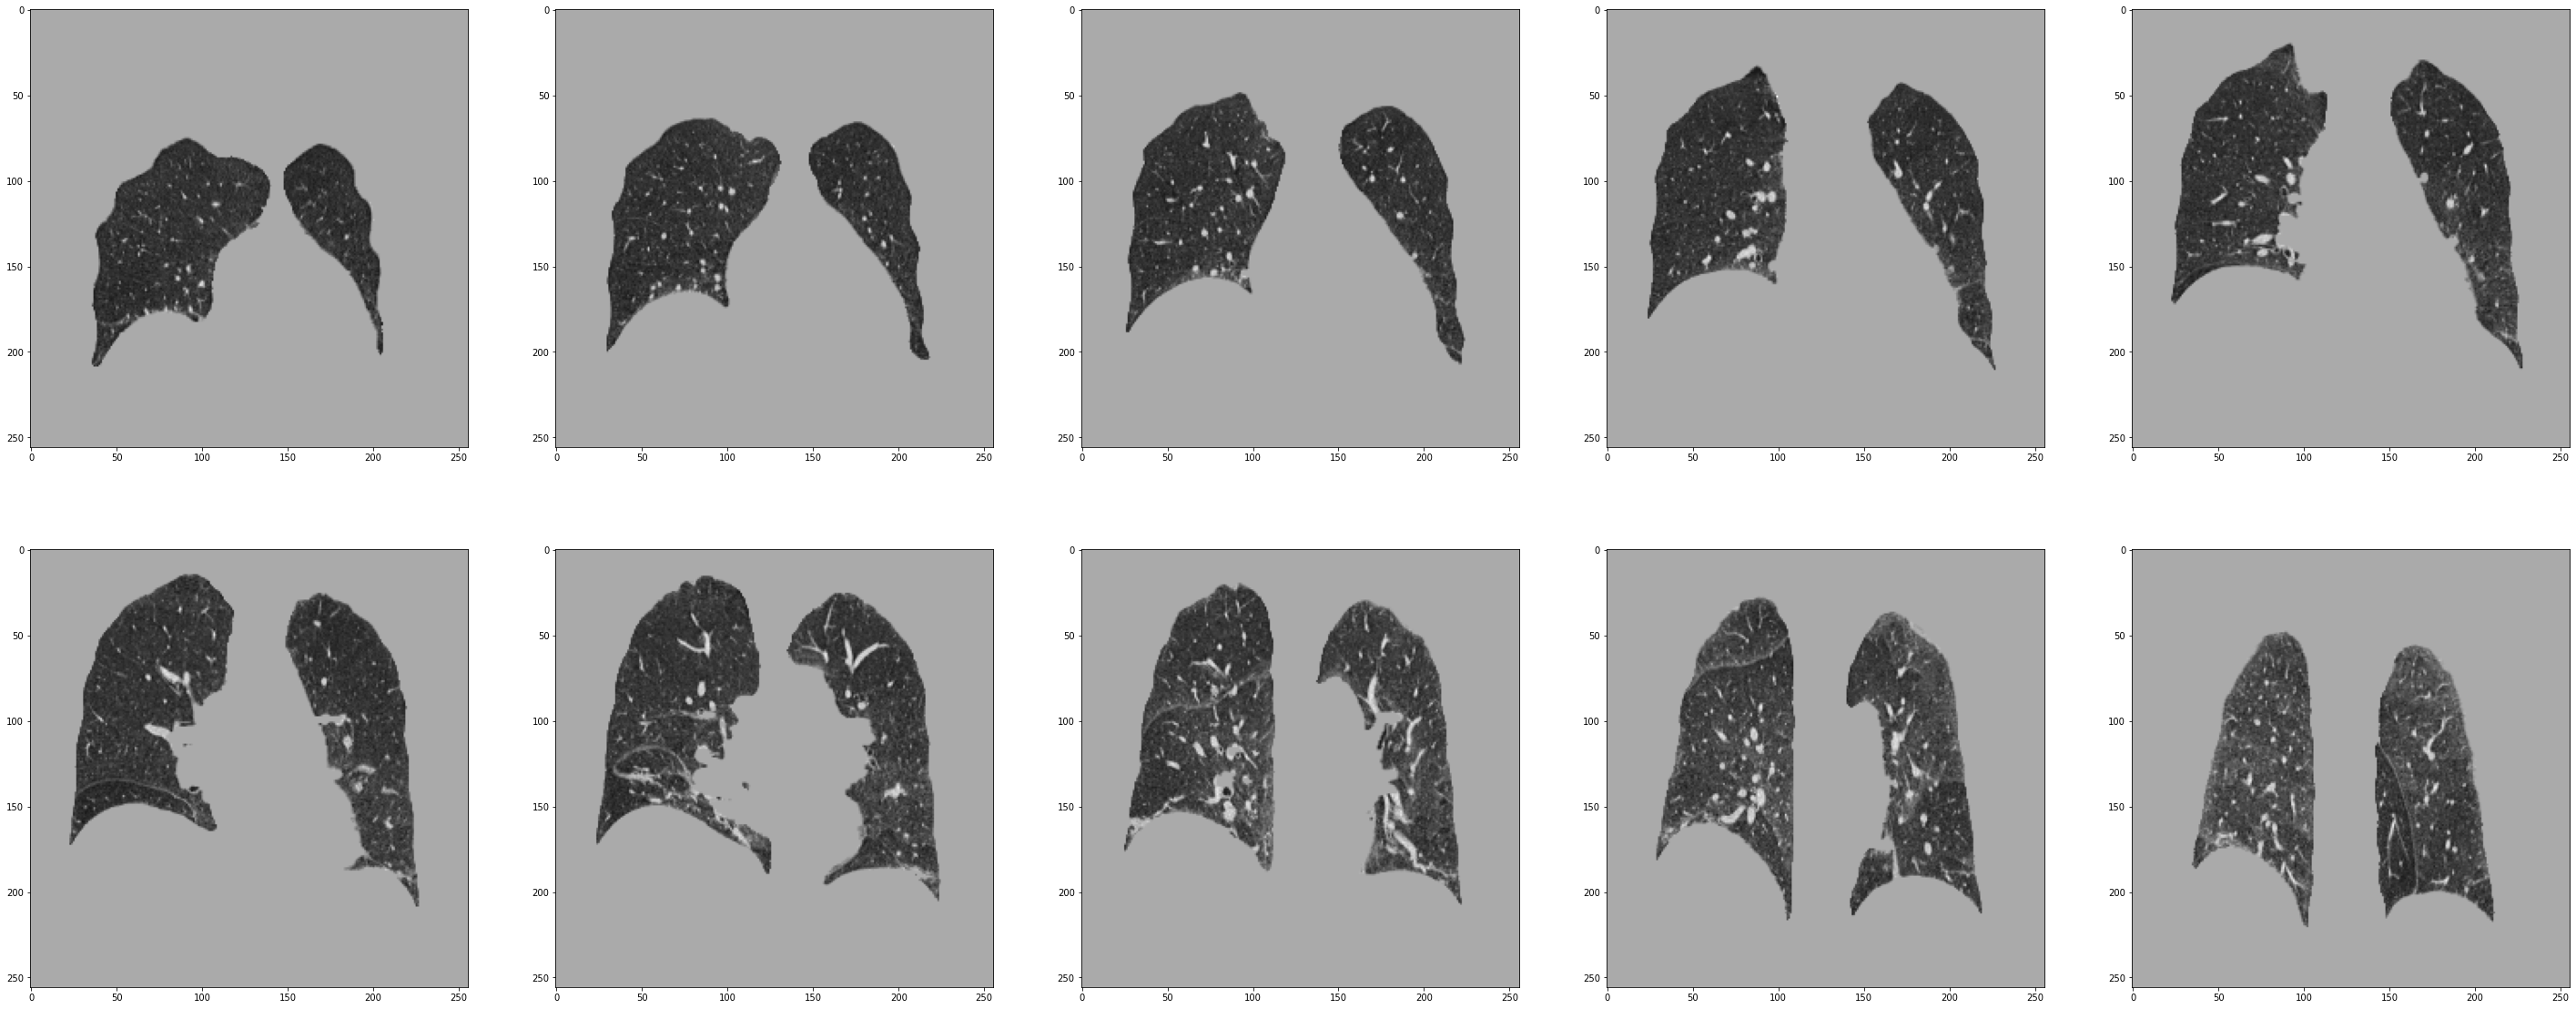

image_data1.shape :torch.Size([1, 10, 256, 256])


In [5]:
# NII格式CT图像
# 首次运行lung_mask提取算法会从github下载模型，如果下载失败，请直接将models/lungmsk/中的unet模型复制到本地
ct_image_path = 'example_data/image/example_CT.nii.gz'
lung_mask_npy1 = lung_mask_extract(ct_image_path, image_format='NII')
pixel_means = np.load('example_data/normalize/slice_means.npy')
pixel_stds = np.load('example_data/normalize/slice_stds.npy')
image_data1 = CT_lung_mask_2_X_ray_10(lung_mask_npy1, pixel_means, pixel_stds, crop_size=(512, 512), target_shape=(256,256), show_img=True, device=device)
print(f"image_data1.shape :{image_data1.shape}")

device:  cuda


 97%|█████████▋| 23/23.65 [00:02<00:00,  9.33it/s]/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
101%|██████████| 24/23.65 [00:02<00:00,  9.30it/s]

lungmask 2025-08-11 05:41:43 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 67.96it/s]


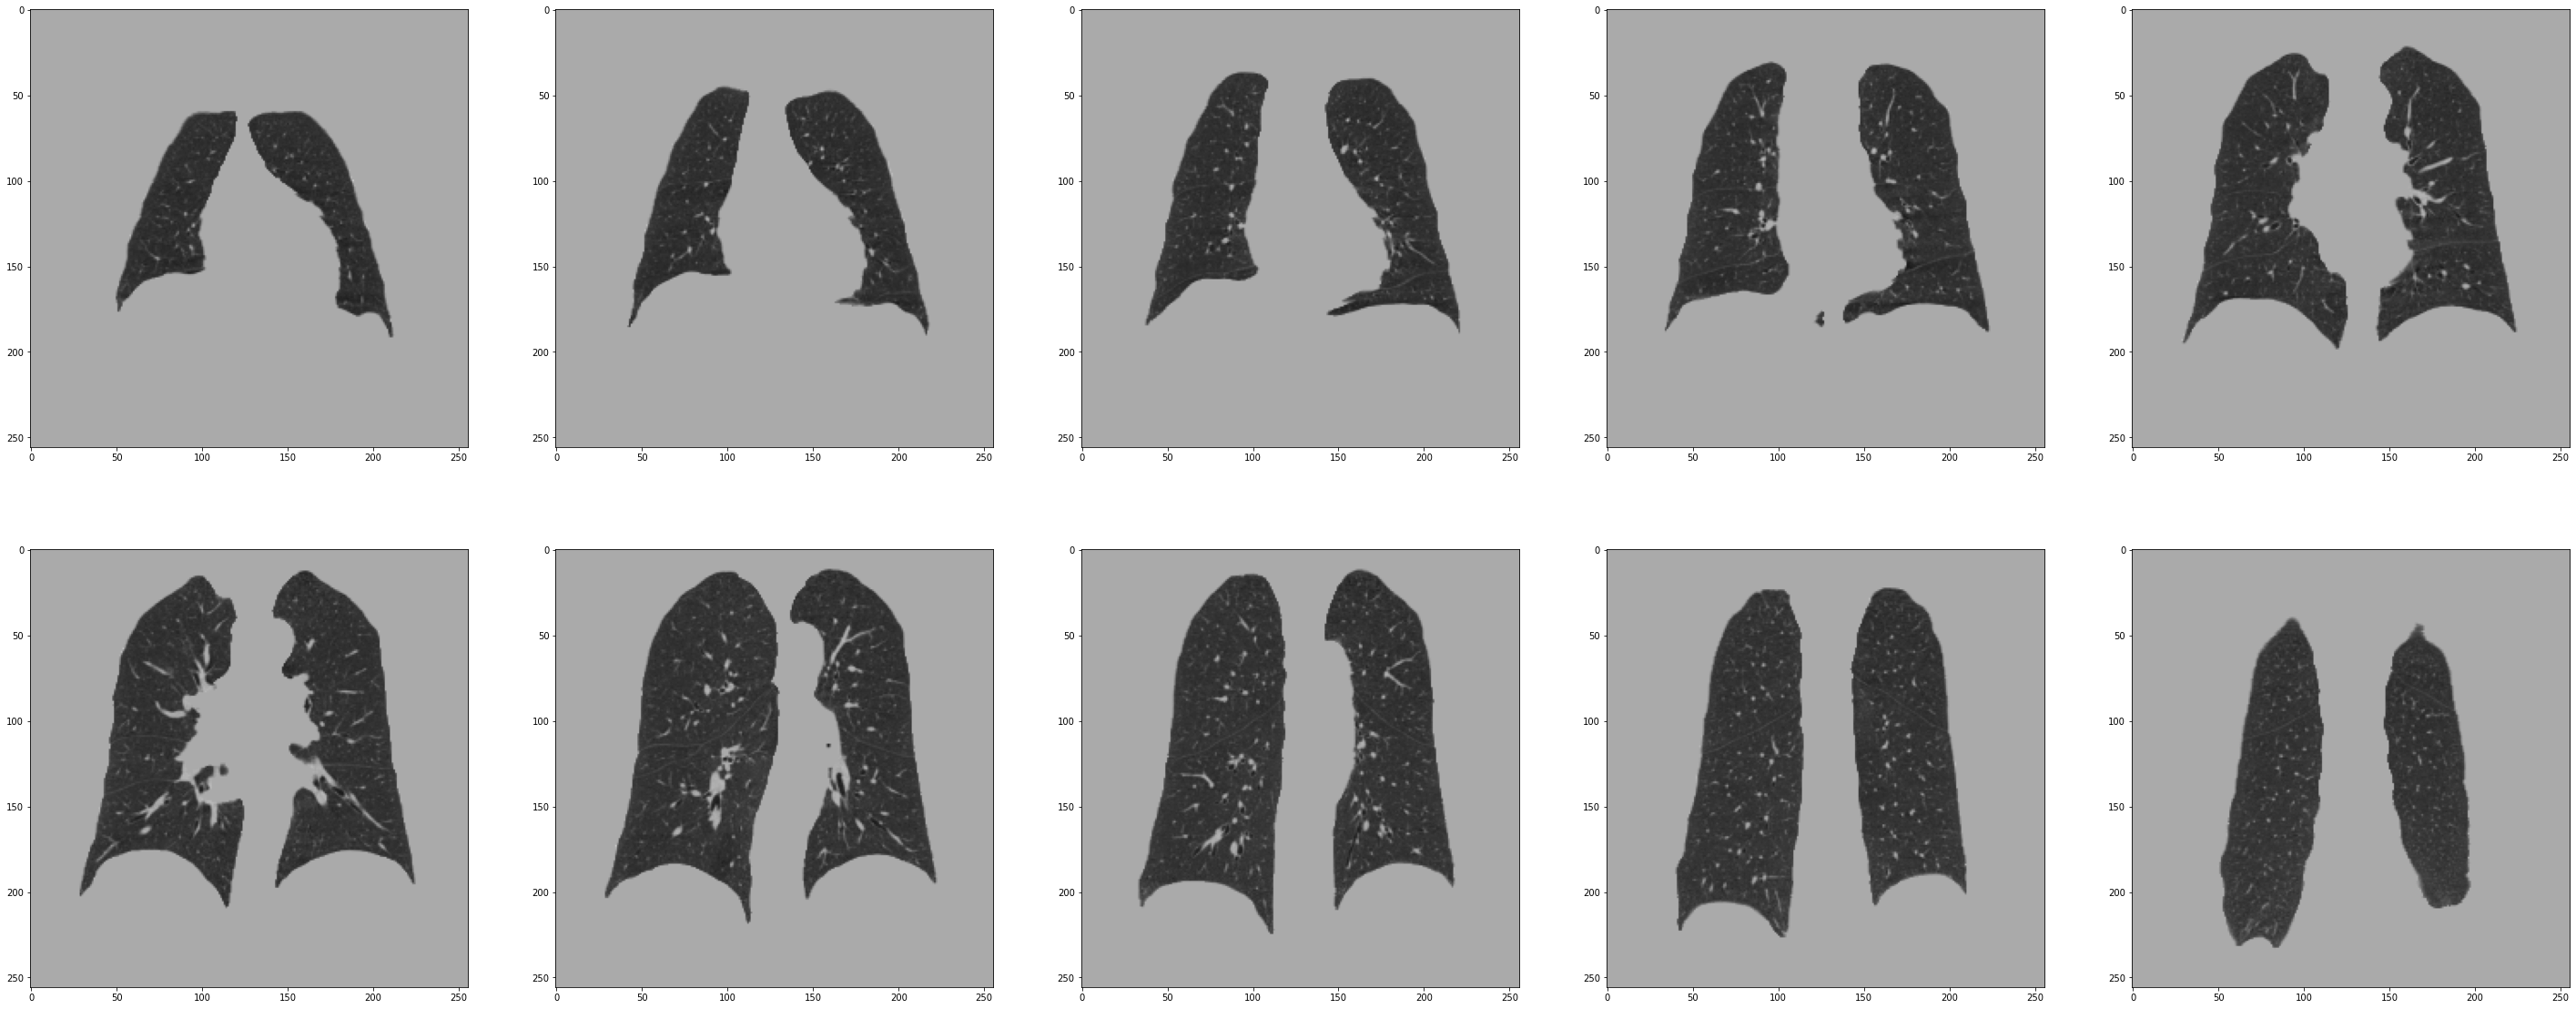

image_data2.shape :torch.Size([1, 10, 256, 256])


In [6]:
# DICOM格式图像
ct_image_path = 'example_data/image/example_CT_DICOM/'
lung_mask_npy2 = lung_mask_extract(ct_image_path, image_format='DICOM')
image_data2 = CT_lung_mask_2_X_ray_10(lung_mask_npy2, pixel_means, pixel_stds, crop_size=(512, 512), target_shape=(256,256), show_img=True, device=device)
print(f"image_data2.shape :{image_data2.shape}")

# 输入2（必须）：患者写变量信息，性别、年龄（岁）、身高（厘米）、体重（千克）

In [7]:
sex = 1  # 0: male; 1: female
age = 59  # unit: year
height = 163  # unit: cm
weight = 72  # unit: kg
corvs = [sex, age, height, weight]
corvs_tensor = torch.tensor(corvs).to(torch.float32).to(device)
corvs_tensor = corvs_tensor.unsqueeze(0)
print(f"corvs_tensor.shape :{corvs_tensor.shape}")

corvs_tensor.shape :torch.Size([1, 4])


In [8]:
# med-bert用于文本数据嵌入
tokenizer = BertTokenizer.from_pretrained('models/medbert-base-chinese');
bert_model = BertModel.from_pretrained('models/medbert-base-chinese');
bert_model.to(device);
# pkuseg模型用于CT报告文本分词
seg = pkuseg.pkuseg(model_name='models/pkuseg/medicine');

# 输入3（可选）：CT报告文本

In [9]:
CT_report = '胸廓对称，纵隔居中。气管及叶段支气管通畅。双肺支气管血管束增多增粗、走形未见明显异 常。左肺下叶体积缩小，近肺门处可见团片状实变影，内见粗细不均支气管影；右肺下叶前基 底段粗大索条影伴局部支气管扩张；右肺中下叶及左肺下叶散在斑片状磨玻璃密度影，可见马 赛克征；纵隔内散在小淋巴结显示。心脏、大血管形态、大小未见异常。双侧胸膜局限性增厚。 双侧胸腔及心包未见明显积液。左肺下叶体积缩小，其内团片实变影，较2017-02-27 略进展，建议结合临床定期复查； 双肺局部细支气管炎； 右肺下叶、右肺中叶陈旧性病变； 双侧胸膜局限性增厚。'
# pkuseg模型用于CT报告文本分词
seg = pkuseg.pkuseg(model_name='models/pkuseg/medicine')
# all_auc_dicts用于筛选CT报告文本分词结果
word_auc_json_path = 'example_data/report_words_filter/auc_sorted_dicts.json'
with open(word_auc_json_path, 'r', encoding='utf-8') as f:
    all_auc_dicts = json.load(f)
# CT报告文本嵌入张量，形状为batch_size*769：1维度为0/1，代表筛选后是否为空字符串；2-769维度为med-bert输出CLS向量
cre = ct_report_embedding(CT_report, bert_model, tokenizer, seg, all_auc_dicts, device=device)
print(f"cre.shape :{cre.shape}")

cre.shape :torch.Size([1, 769])


# 输入4（可选）：大语言模型（DeepSeek-R1）推理文本和预测结果（二者必须同时输入）

网站为用户提供三个分类任务的提示词模板（example_data/DS-R1-prompt/），最好设置成点击下载形式。

用户下载好提示词模板后，将提示词模板中CT报告对应位置替换成要输入的CT报告文本后，将替换好的提示词发送给DeepSeek-R1进行推理，最后将DeepSeek-R1产生的推理文本、预测结果输入到网站中。

In [10]:
LLM_reasonings = ["首先，我需要判断这个患者的FEV1/FVC是否小于70%。FEV1/FVC是判断阻塞性通气功能障碍的关键指标，小于70%通常表示阻塞性问题，如COPD或哮喘。回顾医学常识：如果CT报告中出现以下关键词，FEV1/FVC可能小于70%：- 薄壁透亮影- 肺大- 胸膜增厚- 切除- 术后- 间质性- 纤维化- 大片实变或实变现在，分析患者的CT报告：- CT所见：  - 双肺支气管血管束增多增粗：这可能提示炎症或纤维化，但本身不直接表示阻塞。  - 左肺下叶体积缩小：这通常与限制性通气障碍相关，如肺不张或纤维化，可能影响肺总量，但不一定导致FEV1/FVC降低。FEV1/FVC在限制性疾病中可能正常或偏高。  - 左肺下叶近肺门处团片状实变影：实变是关键词之一（大片实变或实变），实变可能影响通气，导致阻塞或限制。实变区域可能引起气流受限。  - 内见粗细不均支气管影：这可能表示支气管扩张或变形，提示慢性炎症，可能导致阻塞。  - 右肺下叶前基底段粗大索条影伴局部支气管扩张：支气管扩张是阻塞性疾病的常见特征，如COPD或支气管炎，可能导致FEV1/FVC降低。  - 右肺中下叶及左肺下叶散在斑片状磨玻璃密度影，可见马赛克征：磨玻璃密度影和马赛克征通常与间质性肺病或小气道疾病相关，可能引起阻塞性或限制性功能障碍。马赛克征常表示空气滞留，是小气道阻塞的标志。  - 双侧胸膜局限性增厚：胸膜增厚是关键词之一（胸膜增厚），通常与限制性疾病相关，但也可能伴随阻塞。  - 纵隔内散在小淋巴结：可能表示炎症，但不直接影响肺功能。- CT诊断：  - 左肺下叶体积缩小，团片实变影，考虑发育异常或陈旧病变：陈旧病变可能包括纤维化，是关键词（纤维化）。  - 双肺局部细支气管炎：细支气管炎是直接的小气道炎症，常见于阻塞性疾病，可能导致FEV1/FVC降低。  - 右肺下叶、右肺中叶陈旧性病变：陈旧病变可能暗示纤维化或瘢痕。  - 双侧胸膜局限性增厚：再次确认胸膜增厚。关键点总结：- 报告中有实变（团片状实变影）- 支气管扩张（局部支气管扩张）。- 细支气管炎（明确诊断）。- 马赛克征（表示空气滞留，阻塞性特征）。- 胸膜增厚。- 纤维化暗示（陈旧病变）。这些关键词（实变、支气管扩张、细支气管炎、马赛克征、胸膜增厚）都与可能导致FEV1/FVC降低的阻塞性或混合性肺病相关。特别是细支气管炎和支气管扩张是阻塞性疾病的强指标。患者协变量：- 性别：女- 年龄：59岁- 身高：163.0 cm- 体重：72.0 kg计算BMI：体重72kg，身高1.63m，BMI = 72 / (1.63)^2 ≈ 72 / 2.6569 ≈ 27.1，属于超重。超重可能导致限制性通气障碍，但这里的主要CT发现指向阻塞性成分。年龄59岁，处于COPD常见年龄组。比较示例：- 在第一个示例中，没有明显阻塞关键词，回答“否”。- 在第二个示例中，有肺大泡（阻塞性），回答“是”。- 在第三个示例中，有癌症但无阻塞关键词，回答“否”。本例中有多个阻塞关键词：细支气管炎、支气管扩张、马赛克征、实变。因此，FEV1/FVC很可能小于70%，因为阻塞性元素突出。置信度：我认为有较强的证据支持阻塞性问题。细支气管炎直接关联小气道阻塞，支气管扩张常见于COPD，马赛克征表示空气滞留。实变和胸膜增厚可能混合，但阻塞成分主导。置信度较高，设为0.85。答案：是（0.85）",
                  "首先，我需要判断患者的FEV1占预计值比例是否小于80%。根据医学常识，FEV1降低通常与气道阻塞相关，如肺气肿、肺大泡、气胸、薄壁透亮影、血管束增重或支气管扩张等。这些关键词在CT报告中出现时，可能提示FEV1 < 80%。现在，分析患者的CT报告：- 性别：女- 年龄：38岁- 身高：166.0 cm- 体重：77.0 kg- CT所见：  - 胸廓对称，纵隔居中。  - 气管及叶段支气管通畅。  - 双肺支气管血管束走行、形态未见明显异常。  - 右肺中叶见结节影，大小约1.8×1.7cm，边界清，伴少许索条影。- 纵隔内未见明显肿大淋巴结。- 心脏、大血管形态、大小未见异常。- 双侧胸膜未见明显增厚。- 胸腔及心包未见明显积液。- 甲状腺饱满，密度略不均，气管略受压。- CT诊断：- 右肺中叶结节，考虑良性，建议3个月后复查。- 甲状腺改变，请结合超声检查。关键点：- 报告中没有出现医学常识中提到的关键词：肺气肿、肺大泡、气胸、薄壁透亮影、血管束增重或支气管扩张。- 支气管血管束正常，气管通畅，没有阻塞迹象。- 右肺中叶有结节（1.8×1.7cm），但边界清，考虑良性，伴少许索条影（可能为陈旧性病变）。- 甲状腺饱满导致气管略受压，这可能影响气道，但报告提到“气管及叶段支气管通畅”，所以受压可能不严重。- 没有其他异常如胸膜增厚或积液。与示例比较：- 在第一个示例中，患者有肺结节，但无阻塞性病变，FEV1 不低。- 在第二个示例中，有较大占位，但支气管通畅，FEV1 不低。- 在第三个示例中，有结节和胸膜增厚，但无阻塞，FEV1 不低。- 本例类似：有良性结节，但无阻塞性病变。甲状腺受压气管，但报告强调气管通畅，所以可能不影响FEV1显著。患者特征：- 年龄38岁，相对年轻，肺功能通常较好。- BMI：体重77kg，身高166cm，BMI = 77 / (1.66)^2 ≈ 77 / 2.7556 ≈ 27.95，超重但未到肥胖（30以上），可能轻微影响肺功能，但不一定导致FEV1 < 80%。思考FEV1是否可能低：- FEV1降低主要与阻塞性肺病相关。这里没有证据支持。- 甲状腺受压气管：可能导致上气道阻塞，但报告说“气管及叶段支气管通畅”，且诊断没有强调严重压迫，所以可能不影响下气道或FEV1。- 结节大小1.8cm，在肺中叶，如果不是阻塞气道，应不影响通气功能。因此，基于CT报告，没有迹象表明FEV1会低于80%。置信度：- 报告很干净，没有高危关键词。- 与示例一致，答案应为“否”。- 置信度高，因为无任何阻塞证据。但甲状腺受压是轻微不确定性，所以不完美。- 估计置信度：0.9（高，因为通畅明确）。最终答案：否",
                 "首先，我需要回答的问题是：该患者TLC占预计值的比例是否小于80%？选项是“是”或“否”。我必须只选择其中一个选项，并给出置信度（0-1之间的浮点数）。回顾医学常识：- TLC占预计值<80%表示限制性通气功能障碍。- 关键词提示TLC可能小于80%：胸廓缩小、实变、胸膜增厚、网格影、间质性改变、胸壁畸形、胸壁塌陷。患者信息：- 性别：女- 年龄：59岁- 身高：163.0 cm- 体重：72.0 kg- BMI计算：体重(kg) / 身高(m)^2 = 72 / (1.63)^2 ≈ 72 / 2.6569 ≈ 27.1（超重，但非肥胖）CT报告：- **所见**:  - 胸廓对称，纵隔居中。  - 气管及叶段支气管通畅。  - 双肺支气管血管束增多增粗（可能表示炎症或纤维化）。  - 左肺下叶体积缩小（关键点：体积缩小直接提示肺容量减少）。  - 左肺下叶近肺门处团片状实变影（实变是关键词，可能导致肺容量减少）。  - 实变影内见粗细不均支气管影，增强扫描强化均匀。  - 右肺下叶前基底段粗大索条影伴局部支气管扩张（支气管扩张可能相关，但更常见于阻塞性而非限制性）。  - 右肺中下叶及左肺下叶散在斑片状磨玻璃密度影，可见马赛克征（磨玻璃影和马赛克征可能表示小气道疾病或间质性改变）。  - 纵隔内散在小淋巴结显示（可能无关）。  - 心脏、大血管正常  - 双侧胸膜局限性增厚（关键词：胸膜增厚，可能导致限制性功能障碍）。  - 无胸腔积液。- **诊断**:  - 左肺下叶体积缩小，其内团片实变影，考虑发育异常或陈旧病变（体积缩小和实变直接相关）。  - 双肺局部细支气管炎（可能表示小气道炎症）。  - 右肺下叶、右肺中叶陈旧性病变（陈旧病变可能包括纤维化）。  - 双侧胸膜局限性增厚（胸膜增厚是限制性因素）。现在，分析TLC是否可能小于80%：- **关键阳性发现**:  - 左肺下叶体积缩小：这直接减少肺总量。  - 实变影：实变区域肺组织无功能，减少有效肺容积。- 双侧胸膜局限性增厚：胸膜增厚可限制肺扩张。  - 磨玻璃密度影和马赛克征：可能表示间质性改变或炎症，影响肺顺应性。  - 支气管血管束增多增粗：可能提示慢性炎症或纤维化。  - 陈旧性病变：可能涉及纤维化，导致肺弹性降低。- **阴性或中性发现**:  - 胸廓对称，无胸壁畸形或塌陷。  - 无网格影或明显间质性改变（但磨玻璃影可能相关）。  - 无胸腔积液。  - 患者年龄59岁，肺功能可能随年龄下降，但BMI 27.1（超重）可能轻微限制肺功能，但CT中的结构性变化更显著。比较示例：- 在第一个示例中，有结节和炎症，但无体积缩小或胸膜增厚，答案是否。- 在第二个示例中，有占位和磨玻璃影，但无体积缩小或胸膜增厚，答案是否。- 在第三个示例中，有慢性炎症和肥胖，答案选择是（但置信度中等）。- 本例有更明显的限制性特征：左肺下叶体积缩小、实变、胸膜增厚。这些是直接的关键词。推理：- 体积缩小（shrinkage）是关键词之一（类似胸廓减小）。- 实变是另一个关键词。- 胸膜增厚是关键词。- 这些因素组合起来，很可能导致肺总量减少。- 患者超重，但BMI 27.1不是极端肥胖，结构性变化更主导。- 因此，TLC占预计值很可能小于80%。置信度：- 证据较强：体积缩小、实变、胸膜增厚。- 但诊断提到“发育异常或陈旧病变”，可能不是活动性进展。- 整体来看，高置信度，因为多个关键词出现。- 我会给置信度0.85（基于直接证据）。答案：是"]
LLM_predictions = [1.0, 0.85, 0.0, 0.9, 1.0, 0.85]  # （预测1，置信度1，预测2，置信度2，预测3，置信度3）
# 大模型推理文本嵌入张量，形状为batch_size*3*512*768
llme = llm_reasonings_embedding(LLM_reasonings, bert_model, tokenizer, device=device)
# 如果有大模型预测结果，更新患者写变量信息 1*4->1*10
corvs_LLM = [sex, age, height, weight] + LLM_predictions
corvs_LLM_tensor = torch.tensor(corvs_LLM).to(torch.float32).to(device)
corvs_LLM_tensor = corvs_LLM_tensor.unsqueeze(0)
print(f"llme.shape :{llme.shape}")
print(f"corvs_LLM_tensor.shape :{corvs_LLM_tensor.shape}")

llme.shape :torch.Size([1, 3, 512, 768])
corvs_LLM_tensor.shape :torch.Size([1, 10])


In [11]:
from models import multimodal
# 3个分类任务名称
task_names = ['FEV1/FVC < 70%', 'FEV1% < 80%', 'TLC% < 80%']

# 应用场景1：当用户输入<CT影像>和<患者协变量信息>时，利用模型1预测

In [12]:
# 应用场景1：当用户输入<CT影像>和<患者协变量信息>时，利用模型1预测
model1 = torch.load('./model_ckpts/model_best_checkpoint1.pth', map_location=device)
model1.eval()
thresholds1 = np.load('./model_ckpts/thresholds/best_thres1.npy')
probs1 = model1(image_data1, corvs_tensor)

thresholds1_tensor = torch.tensor(thresholds1, dtype=probs1.dtype, device=probs1.device).unsqueeze(0)
preds1 = (probs1 >= thresholds1_tensor)

print('根据您输入的CT影像和患者基本信息，肺功能障碍预测结果如下：')
for i in range(preds1.shape[1]):
    print(f'{task_names[i]} 预测结果：{preds1[0, i]}')

根据您输入的CT影像和患者基本信息，肺功能障碍预测结果如下：
FEV1/FVC < 70% 预测结果：False
FEV1% < 80% 预测结果：False
TLC% < 80% 预测结果：False


# 应用场景2：当用户输入<CT影像>、<患者协变量信息>和<CT报告文本>时，利用模型2预测

In [13]:
# 应用场景2：当用户输入<CT影像>、<患者协变量信息>和<CT报告文本>时，利用模型2预测
model2 = torch.load('./model_ckpts/model_best_checkpoint2.pth', map_location=device)
model2.eval()
thresholds2 = np.load('./model_ckpts/thresholds/best_thres2.npy')
probs2 = model2(image_data1, corvs_tensor, report=cre)

thresholds2_tensor = torch.tensor(thresholds2, dtype=probs2.dtype, device=probs2.device).unsqueeze(0)
preds2 = (probs2 >= thresholds2_tensor)

print('根据您输入的CT影像、患者基本信息和CT报告，肺功能障碍预测结果如下：')
for i in range(preds2.shape[1]):
    print(f'{task_names[i]} 预测结果：{preds2[0, i]}')

根据您输入的CT影像、患者基本信息和CT报告，肺功能障碍预测结果如下：
FEV1/FVC < 70% 预测结果：True
FEV1% < 80% 预测结果：True
TLC% < 80% 预测结果：True


# 应用场景3：当用户输入<CT影像>、<患者协变量信息>、<CT报告文本>、<LLM推理文本>和<LLM预测结果>时，利用模型3预测

In [14]:
# 应用场景3：当用户输入<CT影像>、<患者协变量信息>、<CT报告文本>、<LLM推理文本>和<LLM预测结果>时，利用模型3预测
model3 = torch.load('./model_ckpts/model_best_checkpoint3.pth', map_location=device)
model3.eval()
thresholds3 = np.load('./model_ckpts/thresholds/best_thres3.npy')
probs3 = model3(image_data1, corvs_LLM_tensor, report=cre, reasoning=llme)

thresholds3_tensor = torch.tensor(thresholds3, dtype=probs3.dtype, device=probs3.device).unsqueeze(0)
preds3 = (probs3 >= thresholds3_tensor)

print('根据您输入的CT影像、患者基本信息、CT报告文本、大模型推理文本和预测结果，肺功能障碍预测结果如下：')
for i in range(preds3.shape[1]):
    print(f'{task_names[i]} 预测结果：{preds3[0, i]}')

根据您输入的CT影像、患者基本信息、CT报告文本、大模型推理文本和预测结果，肺功能障碍预测结果如下：
FEV1/FVC < 70% 预测结果：True
FEV1% < 80% 预测结果：False
TLC% < 80% 预测结果：False
